In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/BouchaudMezard`


In [2]:
using QuadGK, Statistics
using Polynomials, Roots
using JLD2, DataFrames, CSV, LaTeXStrings
import PyPlot as plt
using PyCall

In [ ]:
function smoothed_hill(α_hill::Vector, u::Int)
    k_max = length(α_hill)
    av_α_hill = [mean(α_hill[p+1:u*p]) for p in 1:(k_max ÷ u)]
    
    return av_α_hill
end

function alt_hill_plot_2(x_ranked::Vector, k_max::Int, len::Int; iter::Int=5, smooth::Int=3)
    C(α, L, R) = (log(L)*R^α-log(R)*L^α)/(R^α-L^α)
    D(α, L, R) = (R*L)^α*((log(L)-log(R))/(L^α-R^α))^2
    
    x_ranked_ln = log.(x_ranked)
   
    α_hill = zeros(len)
    θs = collect(range(0.0, stop=log(k_max)/log(length(x_ranked)),length=len))
    ks = ceil.(Int,length(x_ranked).^θs)
    @showprogress for (θi,θ) in enumerate(θs)
        α = 1.0/(mean(x_ranked_ln[1:ks[θi]]) - x_ranked_ln[ks[θi]])
        for p in 2:iter
            α *= 1+(α*(mean(x_ranked_ln[1:ks[θi]])-C(α, x_ranked[ks[θi]], x_ranked[1]))-1)/(α*D(α, x_ranked[ks[θi]], x_ranked[1])-1)
        end
        α_hill[θi] = α
    end
    
    av_α_hill = [mean(α_hill[p+1:smooth*p]) for p in 1:(len ÷ smooth)]
    av_θs = [mean(θs[p+1:smooth*p]) for p in 1:(len ÷ smooth)]
    
    return θs, α_hill, av_θs ,av_α_hill
end


function alt_hill_plot(x_ranked::Vector, k_max::Int, len::Int; smooth::Int=3)
    x_ranked_ln = log.(x_ranked)
   
    α_hill = ones(len)
    θs = collect(range(0.0, stop=log(k_max)/log(length(x_ranked)),length=len))
    ks = ceil.(Int,length(x_ranked).^θs)
    @showprogress for (θi,θ) in enumerate(θs)
        α_hill[θi] /= (mean(x_ranked_ln[1:ks[θi]]) - x_ranked_ln[ks[θi]+1])
    end
    
    av_α_hill = [mean(α_hill[p+1:smooth*p]) for p in 1:(len ÷ smooth)]
    av_θs = [mean(θs[p+1:smooth*p]) for p in 1:(len ÷ smooth)]
    
    return θs, α_hill, av_θs ,av_α_hill
end

function rank05_ols_estimator(x_ranked::Vector, k_max::Int, γ)
    x = log.(x_ranked[1:k_max])
    xmean = mean(x)
    y = [log(k-γ) for k in 1:k_max]
    ymean = mean(y)
    
    # regression log(k-1/2) = a - b log(x_ranked[k])
    b = sum((x.-xmean).*(y.-ymean))/sum((x.-xmean).^2)
    a = ymean - b*xmean
    ypred = a .+ b.*x
    ε = y .- ypred
    errb = sqrt(sum(ε.^2)/((k_max-2)*sum((x.-xmean).^2)))
    erra = errb * sqrt(sum(x.^2)/k_max)
    return a, -b, erra, errb
end

In [3]:
NV = 5000 # number of graph vertices
J = 1.0
Ks = [3, 10, 500]

σ²_cs_GECaM = Vector{Float64}()
σ²_cs_I = Vector{Float64}()

for K in Ks
    σ²_c⁻¹, err = quadgk(x -> sqrt(1-x^2)/(K/sqrt(K-1)-x+sqrt((K/sqrt(K-1)-x)^2-1)), -1.0, 1.0, rtol=1e-5)
    append!(σ²_cs_GECaM, round((pi*sqrt(K-1)*J/K)/(2*σ²_c⁻¹), digits=3))
    append!(σ²_cs_I, round(2*J*(K-1)/K, digits=3))
end

for (Ki,K) in enumerate(Ks)
    println("K = $(K): σ²c_(GECaM) = $(σ²_cs_GECaM[Ki]), σ²c_(I) = $(σ²_cs_I[Ki])")
end

σs = [[1.39,1.48,1.56,1.6,1.62,1.64,1.65,1.67,1.69,1.71,1.73,1.76,1.78,1.8],[1.6,1.69,1.75,1.77,1.78,1.81,1.83,1.86,1.89,1.92,1.94,1.97,2.0,2.03,2.11,2.2],[1.85,1.88,1.91,1.93,1.96,1.99,2.02,2.04,2.07]]
kmaxs = [9000, 35000, 75000]
pareto_lim = 10.0

dt = 0.01
t_init = 0.0
t_end = 1500.0
#=
open("pareto_exp.csv", "w") do f
    write(f, "K,sigma2,alpha,err\n")
end;=#

K = 3: σ²c_(GECaM) = 1.713, σ²c_(I) = 1.333
K = 10: σ²c_(GECaM) = 1.903, σ²c_(I) = 1.8
K = 500: σ²c_(GECaM) = 1.998, σ²c_(I) = 1.996


1500.0

In [7]:
Kdf = []
sdf = []
adf = []
erradf = []

for (Ki, K) in enumerate(Ks)
    for (σi, σ²) in enumerate(σs[Ki])
        xs_joint = []

        seed0 = 1234
        dirpath = "./data/sim/changeG_N-$(NV)_K-$(K)_J-$(J/K)_s2-$(σ²)_dt-$(dt)_T-$(t_end)_seed0-$(seed0)"

        for idx_sim in 1:50
            @load dirpath*"/sol_N-$(NV)_K-$(K)_J-$(J/K)_s2-$(σ²)_dt-$(dt)_T-$(t_end)_$(idx_sim).jld" xs
            for t in 1:size(xs)[2]
                xt = xs[:,t]
                filter!(x->x>pareto_lim, xt)
                append!(xs_joint, xt)
            end
        end

        x_ranked = sort(xs_joint, rev=true)
        x_ranked = convert(Vector{Float64}, x_ranked)
        
        kmax = kmaxs[Ki]
        γ = .5
        (a, b, aerr, berr) = rank05_ols_estimator(x_ranked, kmax, γ)
        
        append!(Kdf, K)
        append!(sdf, σ²)
        append!(adf, b)
        append!(erradf, berr)
    end
end

In [7]:
df = DataFrame(K = Kdf, sigma2 = sdf, alpha = adf, err = erradf)
CSV.write("pareto_exp.csv", df)

UndefVarError: UndefVarError: `Kdf` not defined

In [4]:
df = CSV.read("pareto_exp.csv", DataFrame)

Row,K,sigma2,alpha,err
,Int64,Float64,Float64,Float64
1,3,1.39,2.10391,0.00219267
2,3,1.48,2.0692,0.00227584
3,3,1.56,2.04193,0.00235324
4,3,1.6,2.02927,0.00239299
5,3,1.62,2.02312,0.00241326
6,3,1.64,2.01724,0.0024331
7,3,1.65,2.01443,0.00244262
8,3,1.67,2.00903,0.00246126
9,3,1.69,2.00378,0.00247997


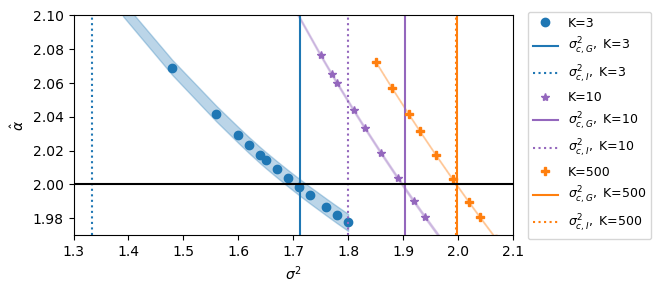

In [5]:
NV = 5000 # number of graph vertices
J = 1.0
Ks = [3, 10, 500]

fig, ax = plt.subplots(1,1, layout="tight", figsize=(6.7,3))  #(15,5)  (6.7,3)
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 9  #9 18

markers=["o", "*", "P"]
lines=["solid", "dotted", "dashed"]
colors=["tab:blue", "tab:purple", "tab:orange"]

for (Ki, K) in enumerate(Ks)
    # Plot data points with error bars and labels
    #ax.scatter(df[df.K .== K, :sigma2], df[df.K .== K, :alpha], label="K=$(K)", marker=markers[Ki], color=colors[Ki])
    ax.plot(df[df.K .== K, :sigma2], df[df.K .== K, :alpha], marker=markers[Ki], linestyle="", color=colors[Ki], label="K=$(K)")
    ax.fill_between(df[df.K .== K, :sigma2], df[df.K .== K, :alpha] .- df[df.K .== K, :err].*1.96, df[df.K .== K, :alpha] .+ df[df.K .== K, :err].*1.96, alpha=0.3, color=colors[Ki])
    
    # Plot vertical lines for sigma^2_c values
    ax.axvline(x=σ²_cs_GECaM[Ki], color=colors[Ki], label=L"\sigma^2_{c, G},"*" K=$(K)", linestyle="solid")
    ax.axvline(x=σ²_cs_I[Ki], color=colors[Ki], label=L"\sigma^2_{c, I},"*" K=$(K)", linestyle="dotted")
end

# Plot horizontal line at y=2.0
ax.axhline(y=2.0, color="black", linestyle="-")

# Set labels and limits
ax.set_xlabel(L"\sigma^2")#, fontsize=15)
ax.set_ylabel(L"\hat{\alpha}")#, fontsize=15)
ax.set_xlim(1.3, 2.1)
ax.set_ylim(1.97, 2.1)

# Add legend
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))#, fontsize=15)

plt.display(fig)

fig.savefig("BM_phasetransition.pdf", format="pdf")

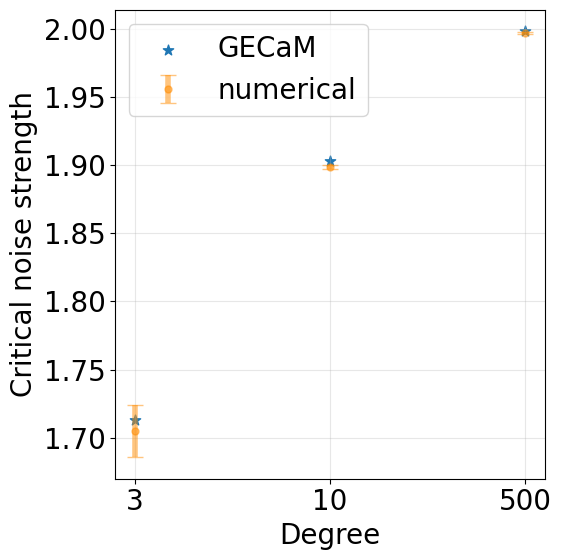

Estimated root (x where y=0): 1.704602207386654
Estimated root (x where y=0): 1.8984757976338273
Estimated root (x where y=0): 1.9967422725468058


In [9]:
fig, ax = plt.subplots(1,1, layout="tight", figsize=(6,6))  #(15,5)  (6.7,3)
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 20  #9 18

markers=["o", "*", "P"]
lines=["solid", "dotted", "dashed"]
colors=["tab:blue", "forestgreen", "darkorange"]

est_alphas = zeros(length(Ks))
est_err_alphas = zeros(length(Ks))
# Example data (replace with your own experimental data)
for (Ki, K) in enumerate(Ks)
    x_exp = df[df.K .== K, :sigma2]
    y_exp = df[df.K .== K, :alpha]
    errors_y = df[df.K .== K, :err].*1.96

    # Step 1: Fit a polynomial to the experimental data
    # Choose a low-degree polynomial (degree 2 or 3 is usually sufficient for simple data)
    p_fit = Polynomials.fit(x_exp, y_exp, 5)  # Quadratic fit

    # Step 2: Find the root of the fitted polynomial (i.e., where y=0)
    # This uses the Roots package to find the root(s) of the polynomial
    x_root = find_zero(p_fit.-2.0, (minimum(x_exp), maximum(x_exp)))  # Find root within the range of x_exp

    println("Estimated root (x where y=0): $x_root")

    # Step 3: Error estimation
    # To estimate the error on the root, we use error propagation
    # Assuming small errors on y, we use the slope of the fitted polynomial at the root

    # First, calculate the derivative of the polynomial
    p_derivative = derivative(p_fit)

    # Evaluate the slope at the estimated root
    slope_at_root = p_derivative(x_root)

    # Estimate the propagated error on x_root
    # We'll take the average error on y_exp (you can refine this with a weighted average if needed)
    mean_error_y = mean(errors_y)
    error_x_root = mean_error_y / abs(slope_at_root)
    
    est_alphas[Ki] = x_root
    est_err_alphas[Ki] = error_x_root
end

xs = 1:length(Ks)

ax.errorbar(xs, est_alphas, yerr=est_err_alphas, alpha=.5, linestyle="", c=colors[3], marker=markers[1],markersize=5, elinewidth=4, capsize=6, label="numerical")
ax.scatter(xs, σ²_cs_GECaM, c=colors[1], marker=markers[2], s=60, alpha=1, label="GECaM")
#ax.scatter(xs, σ²_cs_I, c=colors[2], marker=markers[3], alpha=.9, label=L"\sigma^2_{c, I}")
ax.legend()
ax.set_xticks(xs, labels=Ks)
ax.set_xlabel("Degree")
ax.set_ylabel("Critical noise strength")
ax.grid(alpha=0.3)

plt.display(fig)

#fig.xticks(Ks)
fig.savefig("BM_phasetransition.pdf", format="pdf")